In [2]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook analyzes how well the model in MAVE_trial.ipynb (and MAVE_trial.nbconvert.ipynb)
## learned the data by analyzing the pearson Rs for each cell between inputted raw data and 
## MAVE reconstructed output data
### The notebook also looks at stabilization of loss functions 
##loss_scalers = [100, 1, 0.1, 100]

%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(stringr)
library(tidyr)
library(ggpointdensity)

In [6]:
%%R
Loss <- read.csv('/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/logs/R100_K1_C0.1_T100_high_control_training.log.2022-12-19_10010025.493080', sep ='\t')
colnames(Loss)[2] <- 'Total_Loss'
Loss$Recon_Loss <- str_sub(Loss$Recon_Loss, start = 8, end = 17)
Loss$KLD_Loss <- str_sub(Loss$KLD_Loss, start = 8, end = 13)
Loss$Classification_Loss <- str_sub(Loss$Classification_Loss, start = 8, end = 13)
Loss$Triplet_Loss <- str_sub(Loss$Triplet_Loss, start = 8, end = 13)
Loss[,3:6] <- apply(Loss[,3:6], 2, as.numeric)


Loss$Recon_Loss <- Loss$Recon_Loss/max(Loss$Recon_Loss)
Loss$KLD_Loss <- Loss$KLD_Loss/max(Loss$KLD_Loss)
Loss$Classification_Loss <- Loss$Classification_Loss/max(Loss$Classification_Loss)
Loss$Triplet_Loss <- Loss$Triplet_Loss/max(Loss$Triplet_Loss)


Individual_losses <- pivot_longer(Loss, cols = 3:6, names_to = 'Loss_type', values_to = 'Loss')


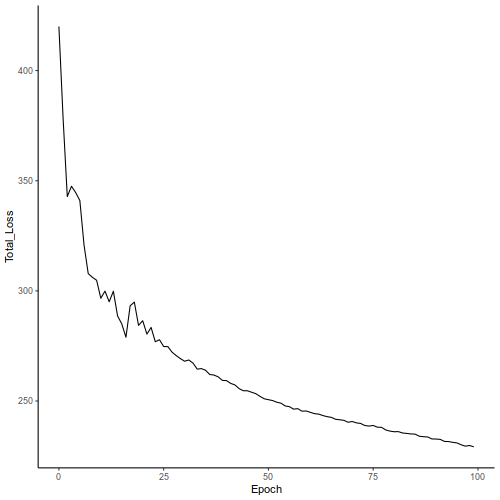

In [7]:
%%R -h 500 -w 500
Total_loss_plot <- ggplot(Loss, aes(Epoch, Total_Loss)) + geom_path() + theme_classic()
Total_loss_plot

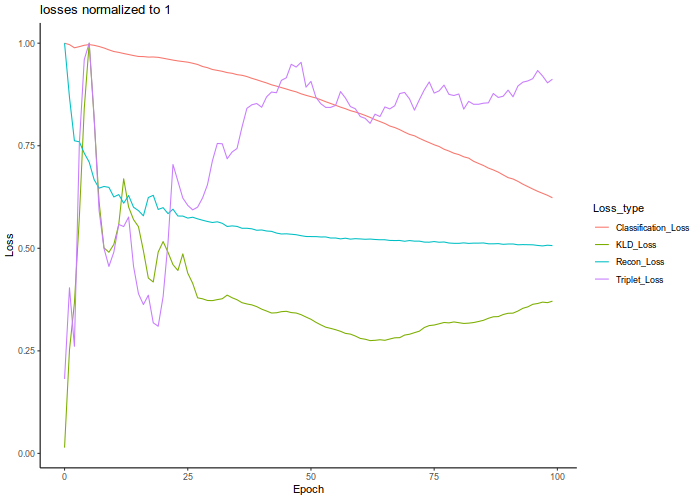

In [8]:
%%R -h 500 -w 700
Individual_loss_plot <- ggplot(Individual_losses, aes(Epoch, Loss, color = Loss_type)) + geom_path() + theme_classic() + ggtitle("losses normalized to 1")
Individual_loss_plot

In [11]:
%%R
Rs <- read.csv('/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/R100_K1_C0.1_T100_high_control_R_tbl.csv')

epoch_1 = as.numeric(Rs[1,])
epoch_50 = as.numeric(Rs[50,])
epoch_100 = as.numeric(Rs[100,])

df <- data.frame(epoch_1, epoch_50, epoch_100)
df <- pivot_longer(df, cols = 1:3, names_to = 'Epoch', values_to = 'Rs')

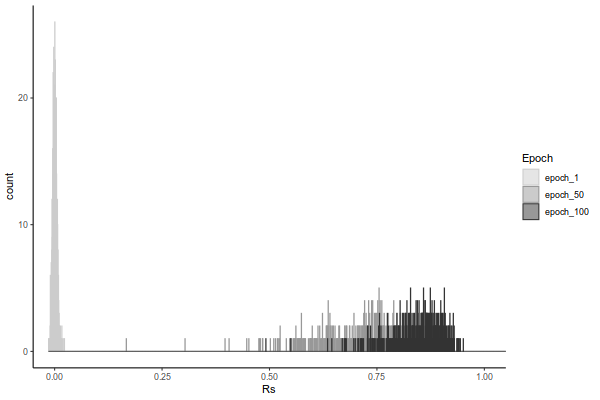

In [12]:
%%R -h 400 -w 600
df$Epoch <- factor(df$Epoch, levels = c('epoch_1', 'epoch_50', 'epoch_100'))
R_learning <- ggplot(df, aes(x=Rs, fill=Epoch, color=Epoch)) +
geom_histogram(position="identity", alpha=0.5, bins = 200000) + scale_color_grey(start = 0.8, end = 0.2) +
scale_fill_grey(start = 0.8, end = 0.2) +
theme_classic() + coord_cartesian(xlim = c(0,1))
R_learning

In [13]:
%%R
medians <- matrixStats::rowMedians(as.matrix(Rs))
Loss$medians <- medians

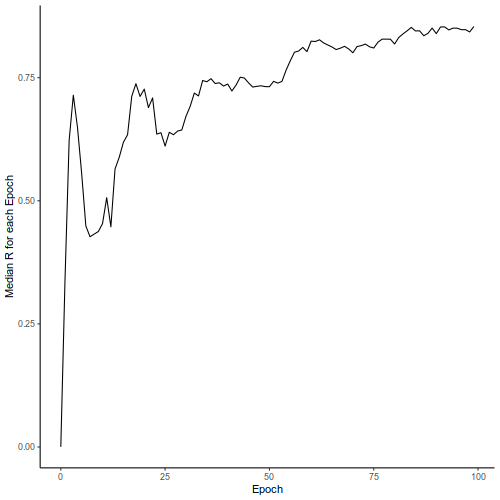

In [14]:
%%R -h 500 -w 500
R_median_plot <-ggplot(Loss, aes(Epoch, medians)) + geom_path() + ylab('Median R for each Epoch') + theme_classic()
R_median_plot

In [15]:
%%R
UMAP_output <- read.csv("/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/R100_K1_C0.1_T100_high_control_UMAP-OF-MU.tsv.gz", sep = '\t', row.names = 1)
head(UMAP_output)

                             UMAP1     UMAP2            guide
miR_2:CAACGATAGCTCGCAC-1 2.7111250 0.3052765  hsa-miR-1226-5p
miR_2:TCCTCCCAGGCAGTCA-1 0.6887944 2.1321290  hsa-miR-3130-3p
miR_2:TAACGACGTATCCCTC-1 1.6121985 4.4416304     hsa-miR-3662
miR_1:TTCCGGTGTTTCTTAC-1 7.7484270 5.5651445     hsa-miR-1262
miR_2:CGCATAACACGCGTGT-1 1.6829847 6.7255520 hsa-miR-26a-1-3p
miR_2:GAGTGAGGTCGTATGT-1 6.8010770 7.0798306           TuD_NC


In [16]:
%%R
library(dplyr)
MAVE_latent_2dims <- read.csv("/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/R100_K1_C0.1_T100_high_control_scMAVE_mu-matrix.tsv.gz", sep = '\t', row.names = 1)
MAVE_latent_2dims <- select(MAVE_latent_2dims, LV.mu.0, LV.mu.1)
MAVE_latent_2dims$guide <- UMAP_output$guide
head(MAVE_latent_2dims)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




                             LV.mu.0    LV.mu.1            guide
miR_2:CAACGATAGCTCGCAC-1  1.45531023  0.7023591  hsa-miR-1226-5p
miR_2:TCCTCCCAGGCAGTCA-1  0.04737091 -0.7597204  hsa-miR-3130-3p
miR_2:TAACGACGTATCCCTC-1  0.20591724  1.1650606     hsa-miR-3662
miR_1:TTCCGGTGTTTCTTAC-1 -1.37625289 -0.7683828     hsa-miR-1262
miR_2:CGCATAACACGCGTGT-1 -0.16119540  1.2144167 hsa-miR-26a-1-3p
miR_2:GAGTGAGGTCGTATGT-1 -0.86487150 -1.2080848           TuD_NC


In [17]:
%%R
guides = unique(MAVE_latent_2dims$guide)
tmp_df = as.data.frame(matrix(0, nrow = nrow(MAVE_latent_2dims), ncol = length(guides)))
colnames(tmp_df) = guides
for (i in 1:length(guides)){
    guide_cells = MAVE_latent_2dims$guide == guides[i]
    vec = MAVE_latent_2dims$guide
    vec[guide_cells] = 'Guide'
    vec[!guide_cells] = 'N/A'
    tmp_df[,i] <- vec
}
MAVE_latent_2dims = cbind(MAVE_latent_2dims, tmp_df)

In [18]:
%%R
guides = unique(UMAP_output$guide)
tmp_df = as.data.frame(matrix(0, nrow = nrow(UMAP_output), ncol = length(guides)))
colnames(tmp_df) = guides
for (i in 1:length(guides)){
    guide_cells = UMAP_output$guide == guides[i]
    vec = UMAP_output$guide
    vec[guide_cells] = 'Guide'
    vec[!guide_cells] = 'N/A'
    tmp_df[,i] <- vec
}
UMAP_output_2dims = cbind(UMAP_output, tmp_df)

In [19]:
%%R
print(paste(nrow(MAVE_latent_2dims), 'rows'))
print(paste(ncol(MAVE_latent_2dims), 'columns'))
head(MAVE_latent_2dims[, 1:5])

[1] "500 rows"
[1] "255 columns"
                             LV.mu.0    LV.mu.1            guide
miR_2:CAACGATAGCTCGCAC-1  1.45531023  0.7023591  hsa-miR-1226-5p
miR_2:TCCTCCCAGGCAGTCA-1  0.04737091 -0.7597204  hsa-miR-3130-3p
miR_2:TAACGACGTATCCCTC-1  0.20591724  1.1650606     hsa-miR-3662
miR_1:TTCCGGTGTTTCTTAC-1 -1.37625289 -0.7683828     hsa-miR-1262
miR_2:CGCATAACACGCGTGT-1 -0.16119540  1.2144167 hsa-miR-26a-1-3p
miR_2:GAGTGAGGTCGTATGT-1 -0.86487150 -1.2080848           TuD_NC
                         hsa-miR-1226-5p hsa-miR-3130-3p
miR_2:CAACGATAGCTCGCAC-1           Guide             N/A
miR_2:TCCTCCCAGGCAGTCA-1             N/A           Guide
miR_2:TAACGACGTATCCCTC-1             N/A             N/A
miR_1:TTCCGGTGTTTCTTAC-1             N/A             N/A
miR_2:CGCATAACACGCGTGT-1             N/A             N/A
miR_2:GAGTGAGGTCGTATGT-1             N/A             N/A


In [20]:
%%R
UMAP_output[1:5,c(1,2)]

                             UMAP1     UMAP2
miR_2:CAACGATAGCTCGCAC-1 2.7111250 0.3052765
miR_2:TCCTCCCAGGCAGTCA-1 0.6887944 2.1321290
miR_2:TAACGACGTATCCCTC-1 1.6121985 4.4416304
miR_1:TTCCGGTGTTTCTTAC-1 7.7484270 5.5651445
miR_2:CGCATAACACGCGTGT-1 1.6829847 6.7255520


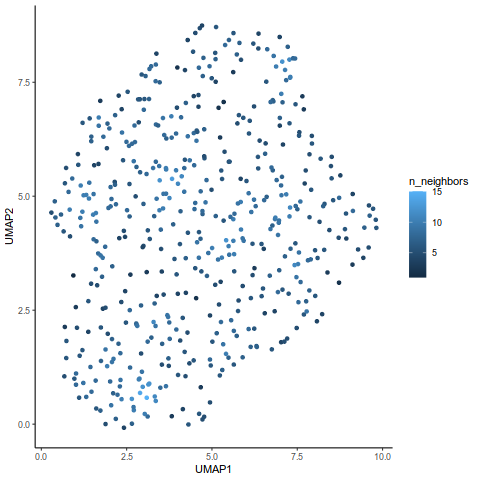

In [21]:
%%R
## density plot of cells plotted in UMAP1/UMAP2 space
library(ggplot2)
library(ggpointdensity)
library(stringr)
ggplot(UMAP_output, aes(UMAP1, UMAP2)) + geom_pointdensity() + theme_classic() +
xlab('UMAP1') + ylab('UMAP2')

In [22]:
%%R
MAVE_latent_2dims[1:5,1:5]

                             LV.mu.0    LV.mu.1            guide
miR_2:CAACGATAGCTCGCAC-1  1.45531023  0.7023591  hsa-miR-1226-5p
miR_2:TCCTCCCAGGCAGTCA-1  0.04737091 -0.7597204  hsa-miR-3130-3p
miR_2:TAACGACGTATCCCTC-1  0.20591724  1.1650606     hsa-miR-3662
miR_1:TTCCGGTGTTTCTTAC-1 -1.37625289 -0.7683828     hsa-miR-1262
miR_2:CGCATAACACGCGTGT-1 -0.16119540  1.2144167 hsa-miR-26a-1-3p
                         hsa-miR-1226-5p hsa-miR-3130-3p
miR_2:CAACGATAGCTCGCAC-1           Guide             N/A
miR_2:TCCTCCCAGGCAGTCA-1             N/A           Guide
miR_2:TAACGACGTATCCCTC-1             N/A             N/A
miR_1:TTCCGGTGTTTCTTAC-1             N/A             N/A
miR_2:CGCATAACACGCGTGT-1             N/A             N/A


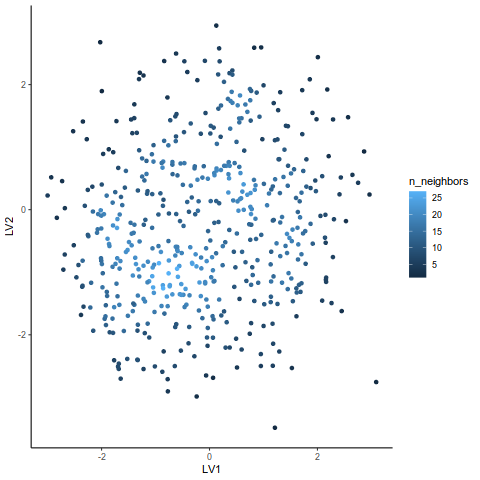

In [23]:
%%R
## density plot of cells plotted in LV.mu.0/LV.mu.1 space
library(ggplot2)
library(ggpointdensity)
library(stringr)
ggplot(MAVE_latent_2dims[,c(1,2)], aes(LV.mu.0, LV.mu.1)) + geom_pointdensity() + theme_classic() +
xlab('LV1') + ylab('LV2')


In [24]:
%%R
plts <- list()
for (i in 1:length(1:length(guides))){
    tmp <- MAVE_latent_2dims[,c(1,2,(i+3))]
    colnames(tmp)[3] <- 'Type'
    tmp <- tmp[order(tmp$Type, decreasing = TRUE),]
    if (str_sub(guides[i], start = 1, end = 6) == 'TuD_NC'){
        plts[[i]] <- ggplot(tmp, aes(LV.mu.0, LV.mu.1, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('#39568CFF', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('LV1') + ylab('LV2')
    } else {
        plts[[i]] <- ggplot(tmp, aes(LV.mu.0, LV.mu.1, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('red', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('LV1') + ylab('LV2')
    }
}


In [25]:
%%R
plts2 <- list()
for (i in 1:length(1:length(guides))){
    tmp <- UMAP_output_2dims[,c(1,2,(i+3))]
    colnames(tmp)[3] <- 'Type'
    tmp <- tmp[order(tmp$Type, decreasing = TRUE),]
    if (str_sub(guides[i], start = 1, end = 6) == 'TuD_NC'){
        plts2[[i]] <- ggplot(tmp, aes(UMAP1, UMAP2, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('#39568CFF', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('UMAP1') + ylab('UMAP2')
    } else {
        plts2[[i]] <- ggplot(tmp, aes(UMAP1, UMAP2, color = Type)) + geom_point() + 
        theme_classic() + scale_color_manual(values = c('red', 'gray95')) + theme(legend.position = 'none', plot.title = element_text(hjust = 0.5)) +
        ggtitle(guides[i]) + xlab('UMAP1') + ylab('UMAP2')
    }
}


In [26]:
%%R
library(ggpubr)
umap_plts <- rep(list('empty'), ceiling(length(plts2)/25))
for (i in 1:ceiling(length(plts2)/25)){
    umap_plts[[i]] <- ggarrange(plotlist = plts2[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, legend = 'none')
}

In [27]:
%%R
library(ggpubr)
latent_plts <- rep(list('empty'), ceiling(length(plts)/25))
for (i in 1:ceiling(length(plts)/25)){
    latent_plts[[i]] <- ggarrange(plotlist = plts[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, legend = 'none')
}

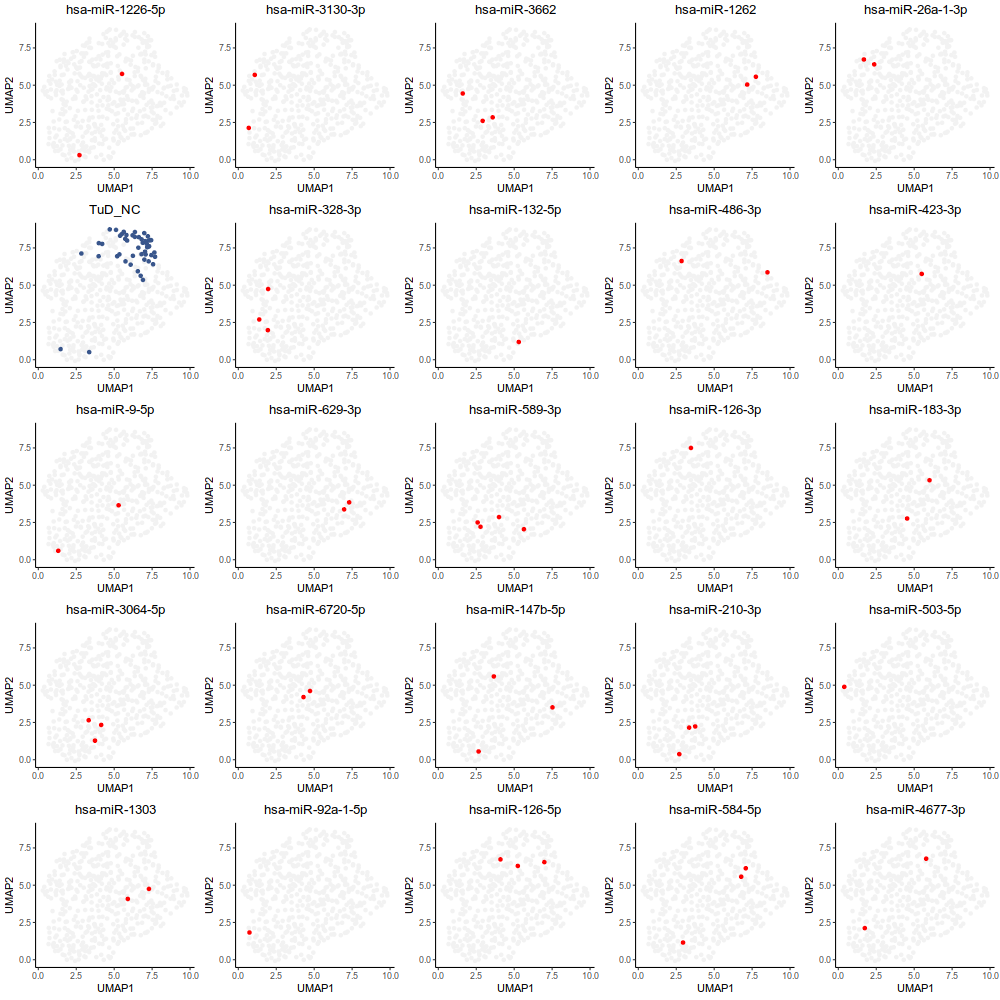

In [28]:
%%R -w 1000 -h 1000
## non-targeting control guides are blue and targeting guides are red
umap_plts[[1]]

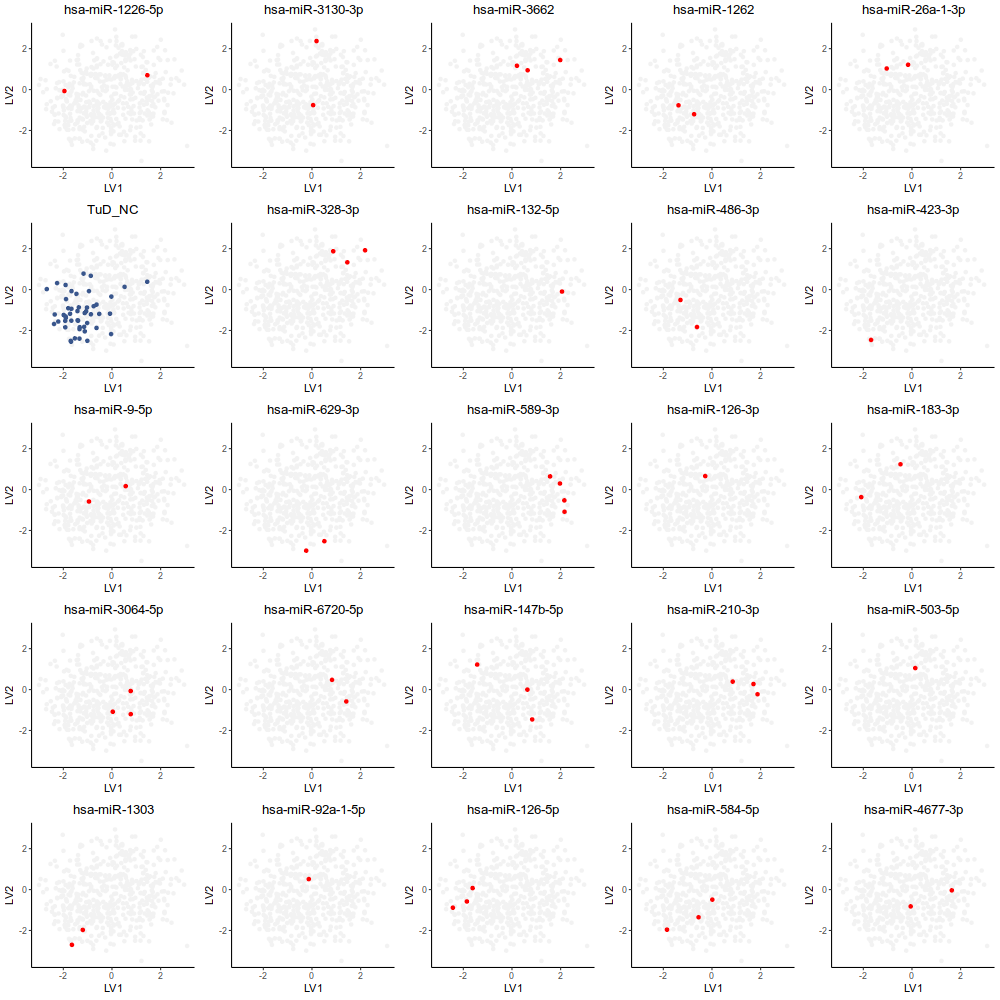

In [29]:
%%R -w 1000 -h 1000
## non-targeting control guides are blue and targeting guides are red
latent_plts[[1]]